# Predicting revenue from ARGA data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Data Preprocessing


In [4]:
df = pd.read_csv('../data/raw/AI Test-1.csv', header=None).T

df.columns = ['time', 'revenue']
df['time'] = df['time'].str.replace('.1', '')
df['time'] = pd.to_datetime(df['time'])

# Convert 'revenue' column to numeric, errors='coerce' will convert non-numeric values to NaN
df['revenue'] = pd.to_numeric(df['revenue'])

df.head()

,time,revenue
0,2003-06-30,32187.0
1,2003-06-30,36835.0
2,2004-06-30,39788.0
3,2005-06-30,44282.0
4,2006-06-30,51122.0


In [5]:
df.describe()

,time,revenue
count,22,14.000000
mean,2013-01-14 19:38:10.909090816,62759.785714
min,2003-06-30 00:00:00,32187.000000
25%,2007-09-29 12:00:00,45992.000000
50%,2012-12-29 12:00:00,61452.000000
75%,2018-03-30 18:00:00,76817.500000
max,2023-06-30 00:00:00,93580.000000
std,NaN,20325.633899


In [18]:
print(df.isnull().sum())

time       0
revenue    8
dtype: int64


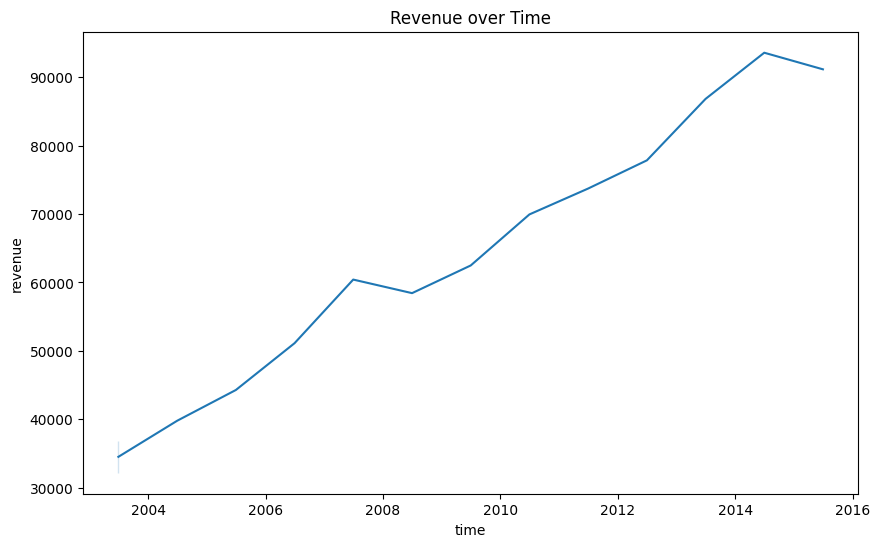

In [6]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='time', y='revenue', data=df)
plt.title('Revenue over Time')
plt.show()

In [7]:
# Separate rows with revenue values (2003-2016) and rows to predict (from 2017 to 2023)
df_with_revenue = df.dropna(subset=['revenue'])
df_to_predict = df[df['revenue'].isna()]

# Create train and dev sets from df_with_revenue
train_df, dev_df = train_test_split(df_with_revenue, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)} values")
print(f"Development set size: {len(dev_df)} values")
print(f"Prediction set size: {len(df_to_predict)} values")

Training set size: 11 values
Development set size: 3 values
Prediction set size: 8 values


## Linear Regression Model

- Instead of splitting data into train-val once initially, we can use KFold Cross Validation to create train-dev split

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

lr = LinearRegression()
k = 5

# Initialize KFold with k=5
kf = KFold(n_splits=k, random_state=42, shuffle=True)

best_model = None
best_score = -np.inf

# Convert datetime columns to integers
for col in train_df.columns:
    if train_df[col].dtype == 'datetime64[ns]':
        train_df.loc[:, col] = train_df[col].view('int64')

# Loop through each fold
for train_index, dev_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    dev_fold = train_df.iloc[dev_index]
    
    X_train = train_fold.drop(columns='revenue')
    y_train = train_fold['revenue']
    X_dev = dev_fold.drop(columns='revenue')
    y_dev = dev_fold['revenue']
            
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_dev)
    
    score = r2_score(y_dev, y_pred)
    
    if score > best_score:
        best_model = lr
        best_score = score

# Convert datetime columns to integers
for col in df_to_predict.columns:
    if df_to_predict[col].dtype == 'datetime64[ns]':
        df_to_predict.loc[:, col] = df_to_predict[col].view('int64')

X_test = df_to_predict.drop(columns='revenue')
y_test_pred = best_model.predict(X_test)

print(f"Best model R^2 score: {best_score}")
print(f"Predicted scores for test set: {y_test_pred}")

Best model R^2 score: 0.9764898690750681
Predicted scores for test set: [ 98456.8138466  103225.3236961  107993.83354559 112762.34339508
 117543.91765512 122312.42750461 127080.93735411 131849.4472036 ]


In [13]:
# Add the predicted values to the df_to_predict DataFrame
df_to_predict.loc[:, 'revenue'] = y_test_pred

# Convert the 'time' column back to datetime
df_to_predict.loc[:, 'time'] = pd.to_datetime(df_to_predict['time'])

df_to_predict.head()

,time,revenue
14,2016-06-30,98456.813847
15,2017-06-30,103225.323696
16,2018-06-30,107993.833546
17,2019-06-30,112762.343395
18,2020-06-30,117543.917655


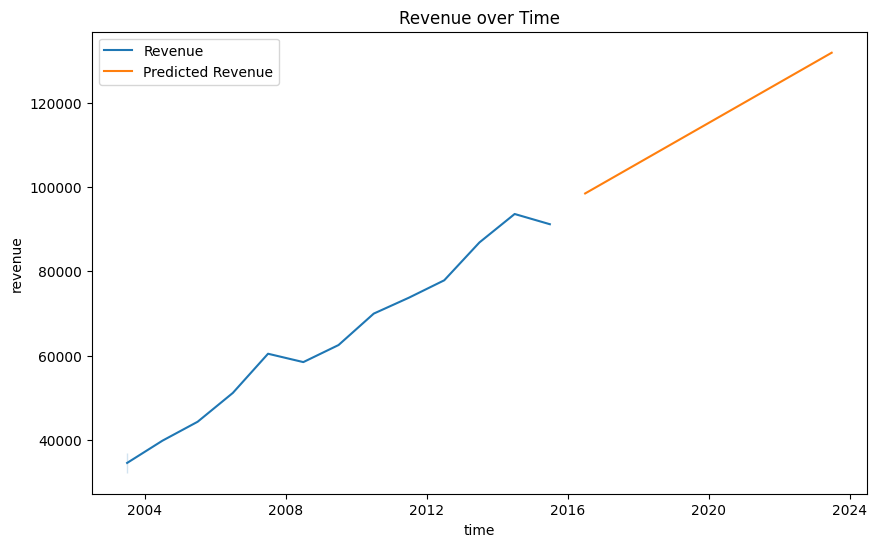

In [14]:
# Plot both with revenue (blue) and predicted revenue (red)
plt.figure(figsize=(10, 6))
sns.lineplot(x='time', y='revenue', data=df_with_revenue, label='Revenue')
sns.lineplot(x='time', y='revenue', data=df_to_predict, label='Predicted Revenue')
plt.title('Revenue over Time')
plt.show()

In [15]:
# Print the line equation for the best linear regression model
coefficients = best_model.coef_
intercept = best_model.intercept_
equation = "y = " + " + ".join([f"{coeff}*x{i}" for i, coeff in enumerate(coefficients, start=1)]) + f" + {intercept}"
print(equation)

y = 1.512084553999475e-13*x1 + -123403.00605500025


In [20]:
# combine the two dataframes
df_combined = pd.concat([df_with_revenue, df_to_predict]).round(2)

df_combined.to_csv('../data/predicted/AI Test-1.csv', index=False)

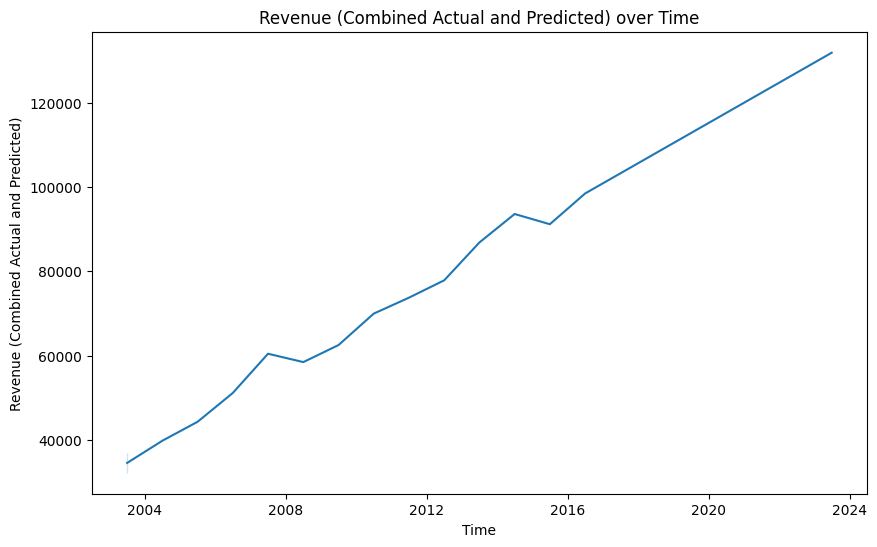

In [25]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='time', y='revenue', data=df_combined)
plt.title('Revenue (Combined Actual and Predicted) over Time')
plt.xlabel('Time')
plt.ylabel('Revenue (Combined Actual and Predicted)')
plt.show()